In [ ]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import torch
import matplotlib.colors as mcolors
from tqdm import tqdm

# Add parent directory to system path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core directory 
from algorithms import OnlineMA, OnlineMARegret

In [ ]:
# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

### Init

In [3]:
print("Loading COMPAS dataset...")
df = pd.read_csv('../data/raw/compas-scores-two-years.csv')
df = df[['compas_screening_date', 'sex', 'race', 'v_decile_score', 'is_recid']]
df = df[df.race.isin(["African-American", "Caucasian", "Hispanic"])]
df['phat'] = df['v_decile_score']/10.0
df.compas_screening_date = pd.to_datetime(df.compas_screening_date)
df = df.sort_values(by='compas_screening_date')

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['compas_screening_date'].min()} to {df['compas_screening_date'].max()}")
print(df.head())

Loading COMPAS dataset...
Dataset shape: (6787, 6)
Date range: 2013-01-01 00:00:00 to 2014-12-31 00:00:00
     compas_screening_date     sex              race  v_decile_score  \
536             2013-01-01    Male          Hispanic               7   
1114            2013-01-01  Female         Caucasian               1   
834             2013-01-01    Male  African-American               9   
6127            2013-01-01    Male         Caucasian               2   
6052            2013-01-01  Female  African-American               2   

      is_recid  phat  
536          0   0.7  
1114         1   0.1  
834          1   0.9  
6127         1   0.2  
6052         0   0.2  


In [4]:
# Prepare tensors as in the helper code
y = torch.tensor(df.is_recid.to_numpy()).float()
yhat = torch.tensor(df.phat.to_numpy()).float()
dummy_df = pd.get_dummies(df.race)
races = torch.tensor(dummy_df.values).float()
order = dummy_df.columns.values.tolist()

print(f"y shape: {y.shape}")
print(f"yhat shape: {yhat.shape}")
print(f"races shape: {races.shape}")
print(f"Race order: {order}")

y shape: torch.Size([6787])
yhat shape: torch.Size([6787])
races shape: torch.Size([6787, 3])
Race order: ['African-American', 'Caucasian', 'Hispanic']


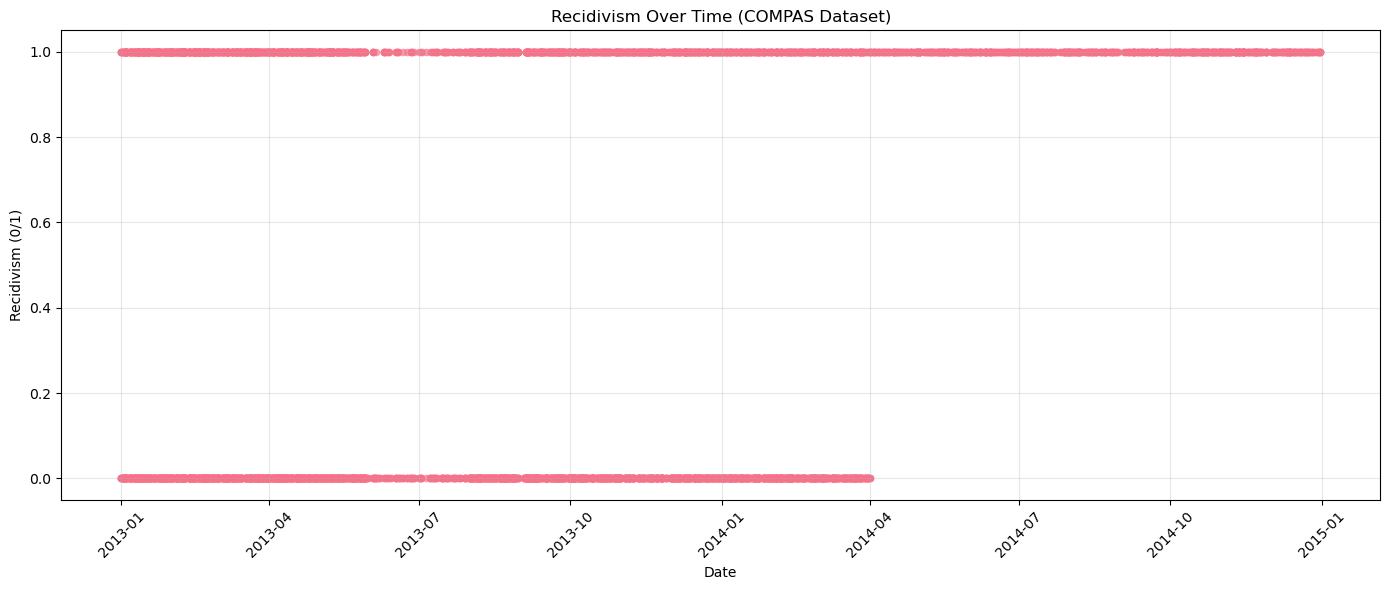

In [5]:
# Plot recidivism over time (basic temporal plot)
plt.figure(figsize=(14, 6))
plt.scatter(df['compas_screening_date'], df['is_recid'], alpha=0.6, s=20)
plt.xlabel('Date')
plt.ylabel('Recidivism (0/1)')
plt.title('Recidivism Over Time (COMPAS Dataset)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Monthly aggregation: 24 months with >= 10 observations


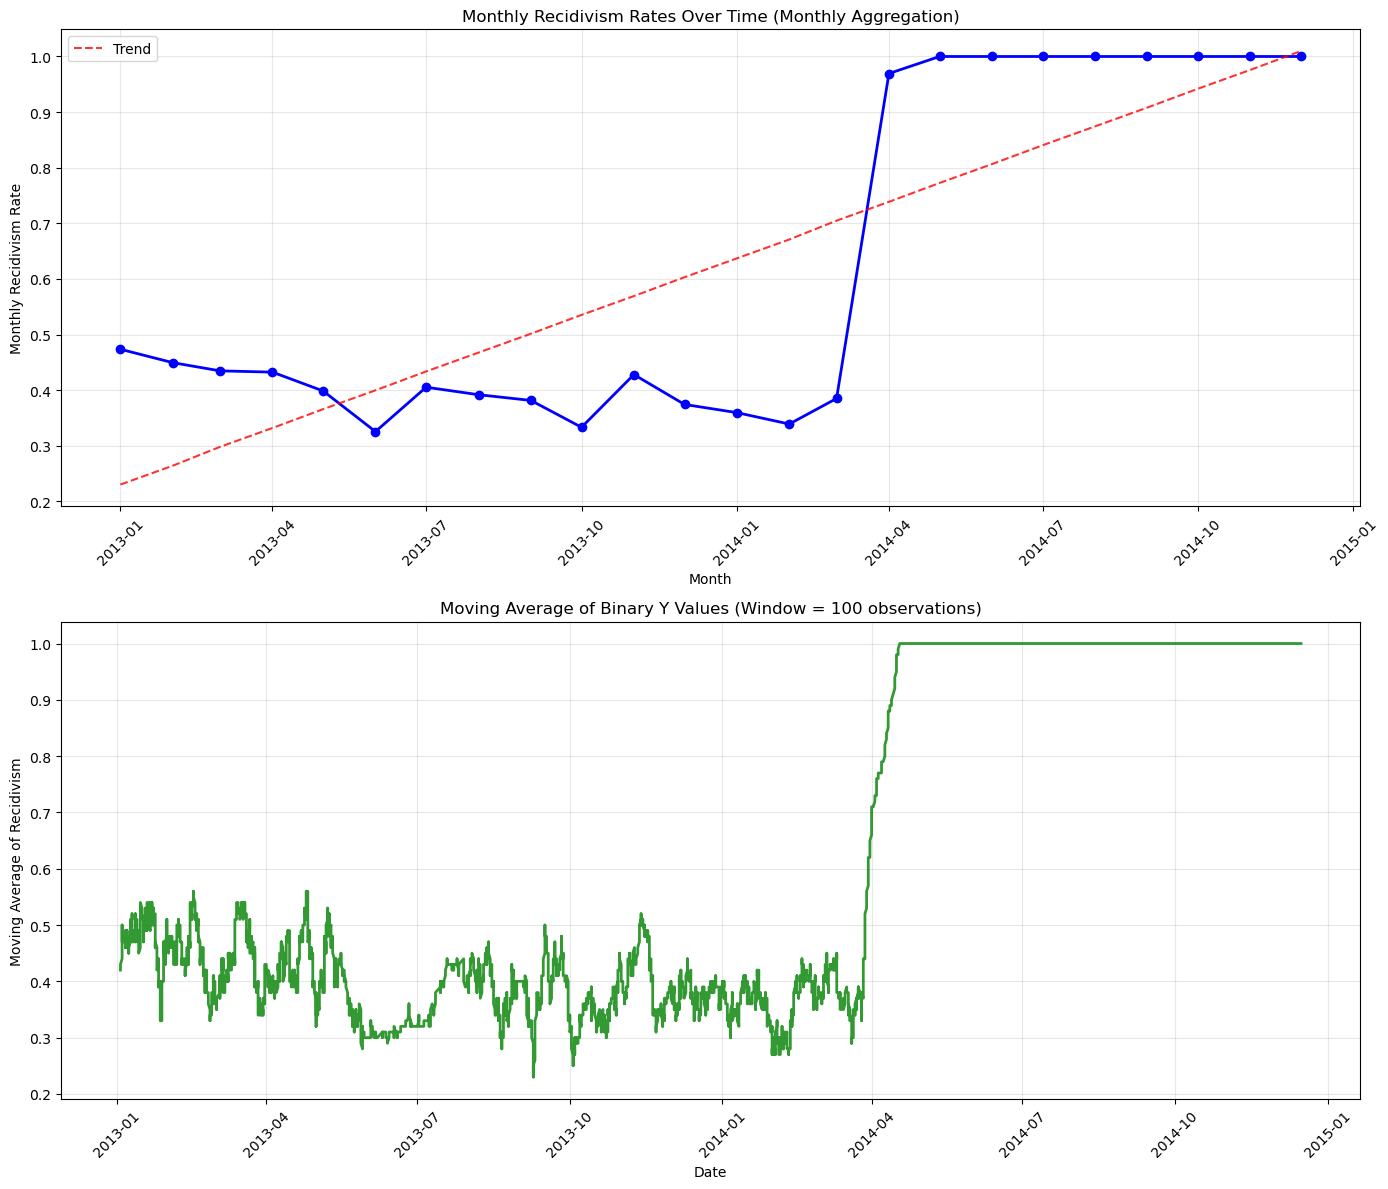

Monthly aggregation recidivism rate: 0.620
Moving average recidivism rate: 0.484

Difference: Monthly aggregation gives you monthly rates
Moving average gives you smoothed individual-level trends


In [6]:
# Create monthly aggregation for clearer temporal trends
df_monthly = df.copy()
df_monthly['year_month'] = df_monthly['compas_screening_date'].dt.to_period('M')
monthly_recid = df_monthly.groupby('year_month')['is_recid'].agg(['mean', 'count']).reset_index()
monthly_recid['year_month'] = monthly_recid['year_month'].dt.to_timestamp()

# Filter out months with very few observations
monthly_recid = monthly_recid[monthly_recid['count'] >= 10]

print(f"Monthly aggregation: {len(monthly_recid)} months with >= 10 observations")

# Calculate TRUE moving average of binary Y values
df_sorted = df.sort_values('compas_screening_date').reset_index(drop=True)
window_size = 100  # Moving average window (number of observations)
df_sorted['moving_avg'] = df_sorted['is_recid'].rolling(window=window_size, center=True).mean()

# Create subplots to show both approaches
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Monthly aggregation (what we had before)
ax1.plot(monthly_recid['year_month'], monthly_recid['mean'], 'o-', linewidth=2, markersize=6, color='blue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Monthly Recidivism Rate')
ax1.set_title('Monthly Recidivism Rates Over Time (Monthly Aggregation)')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add trend line
if len(monthly_recid) > 1:
    z = np.polyfit(range(len(monthly_recid)), monthly_recid['mean'], 1)
    p = np.poly1d(z)
    ax1.plot(monthly_recid['year_month'], p(range(len(monthly_recid))), 
             '--', color='red', alpha=0.8, label='Trend')
    ax1.legend()

# Plot 2: True moving average of binary Y values
# Remove NaN values for plotting
df_ma = df_sorted.dropna(subset=['moving_avg'])
ax2.plot(df_ma['compas_screening_date'], df_ma['moving_avg'], linewidth=2, color='green', alpha=0.8)
ax2.set_xlabel('Date')
ax2.set_ylabel('Moving Average of Recidivism')
ax2.set_title(f'Moving Average of Binary Y Values (Window = {window_size} observations)')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Monthly aggregation recidivism rate: {monthly_recid['mean'].mean():.3f}")
print(f"Moving average recidivism rate: {df_ma['moving_avg'].mean():.3f}")
print(f"\nDifference: Monthly aggregation gives you monthly rates")
print(f"Moving average gives you smoothed individual-level trends")

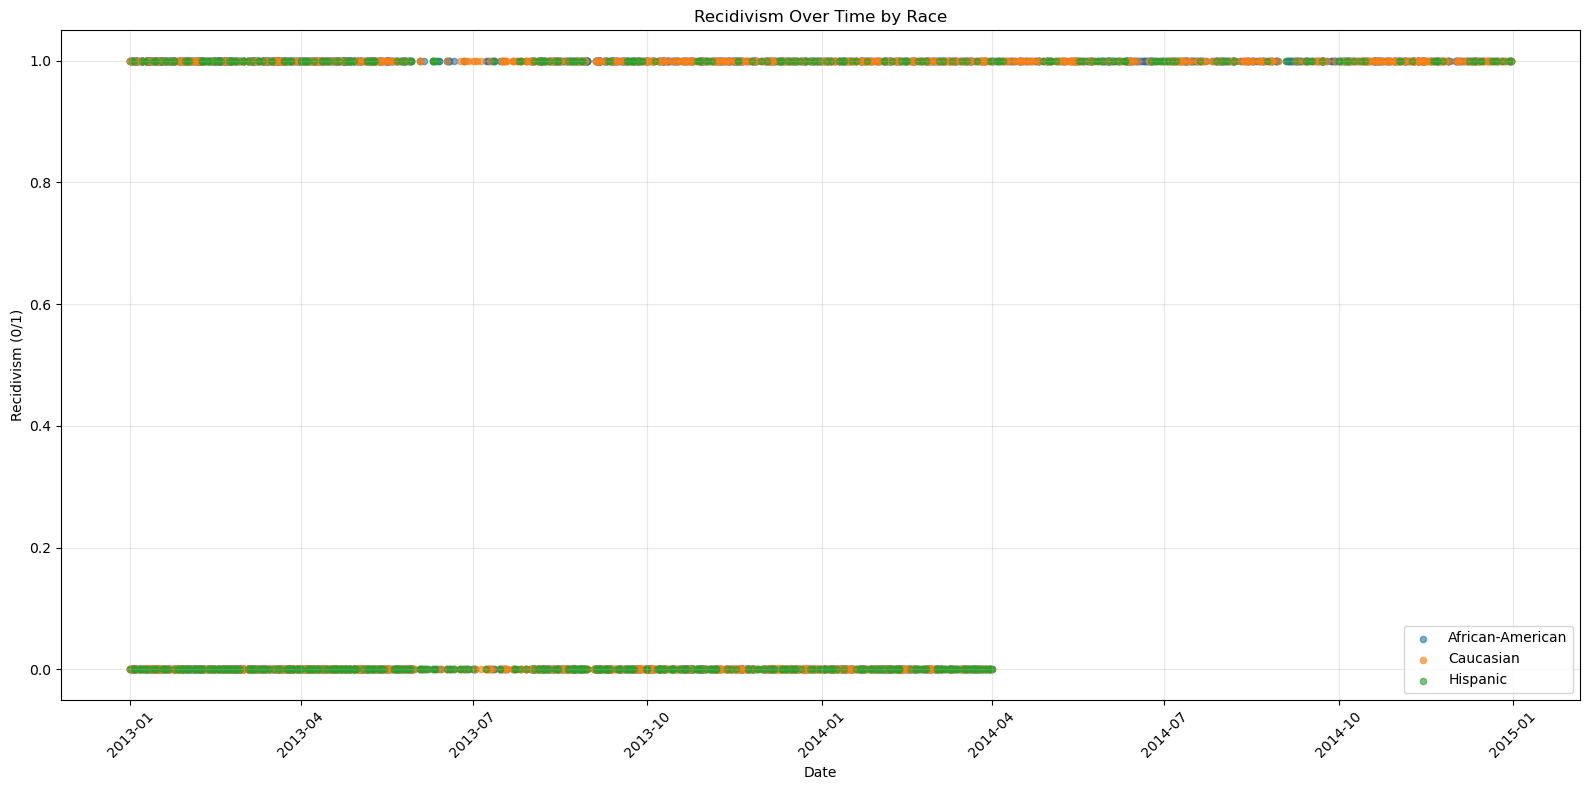

In [7]:
# Plot recidivism vs time by race groups
plt.figure(figsize=(16, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

for i, race in enumerate(order):
    race_data = df[df['race'] == race]
    plt.scatter(race_data['compas_screening_date'], race_data['is_recid'], 
               alpha=0.6, s=20, label=race, color=colors[i])

plt.xlabel('Date')
plt.ylabel('Recidivism (0/1)')
plt.title('Recidivism Over Time by Race')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Monthly race aggregation: 71 month-race combinations with >= 5 observations

Plotting moving averages:
African-American: plotting 3597 points from 2013-01-05 to 2014-12-02
Caucasian: plotting 2355 points from 2013-01-10 to 2014-11-25
Hispanic: plotting 538 points from 2013-02-05 to 2014-06-26


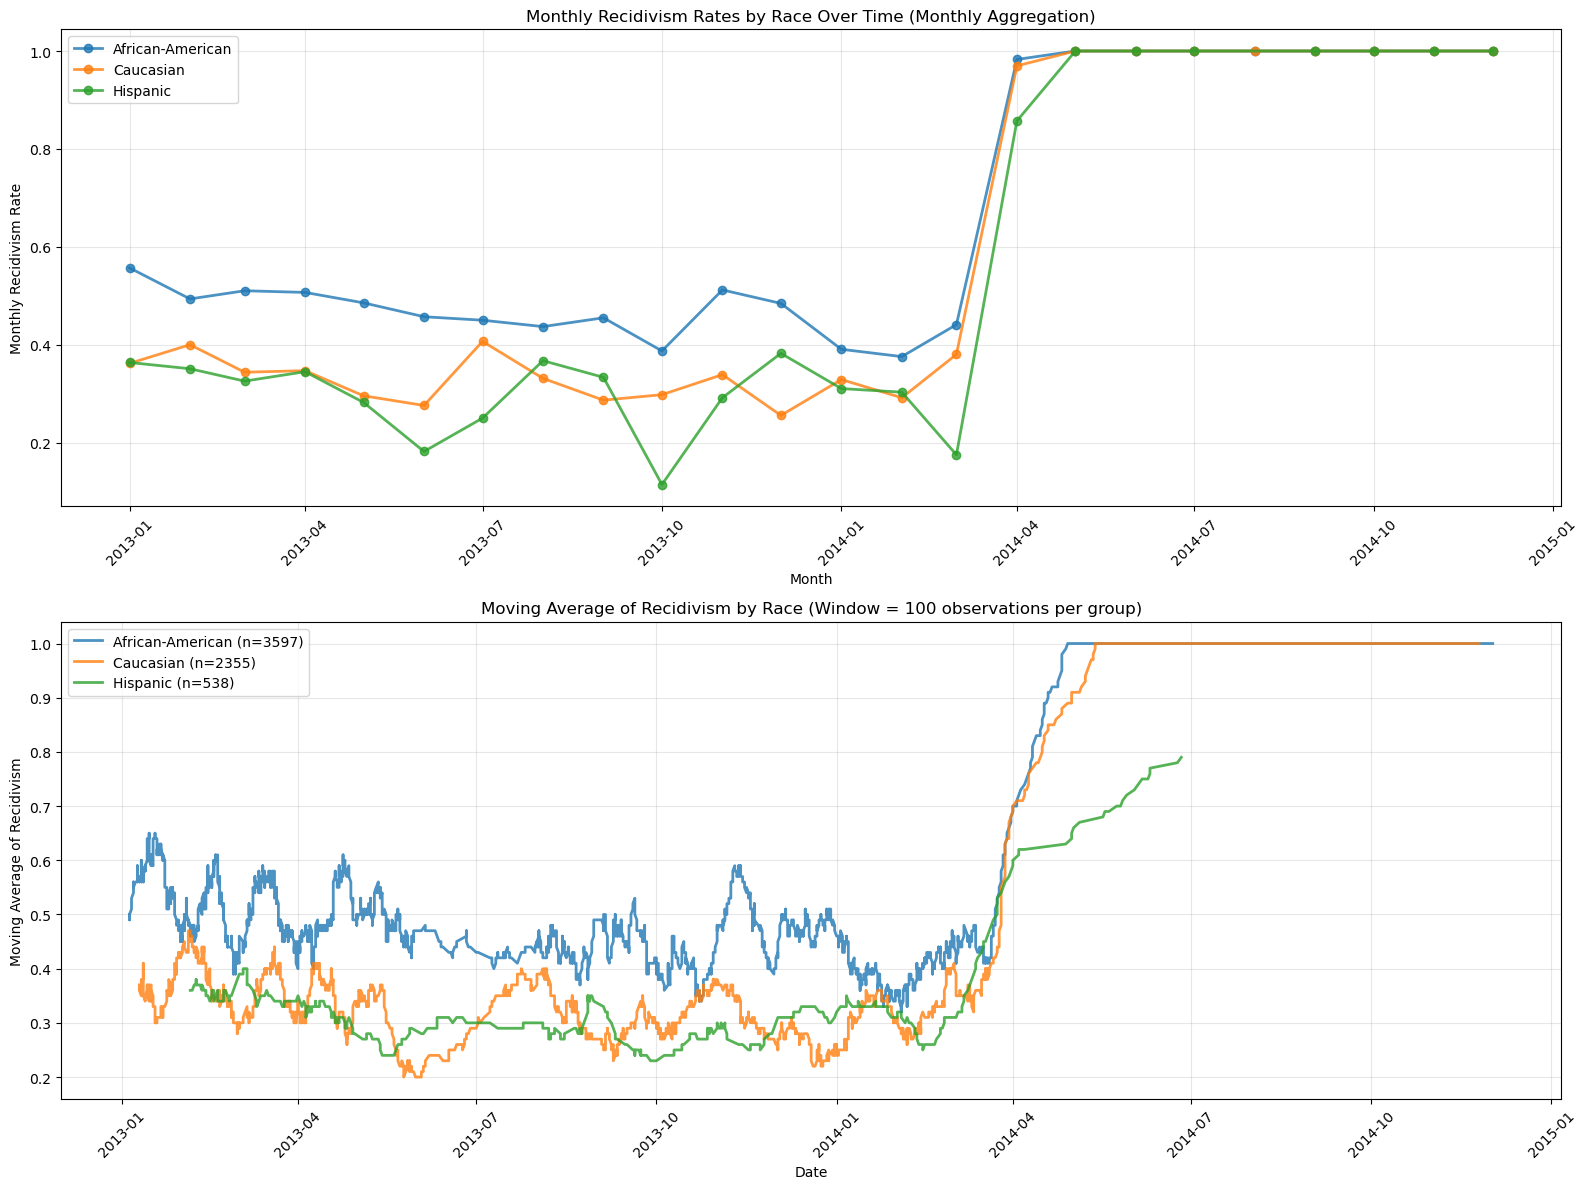


Race-specific recidivism statistics:
African-American: 0.551 (n=3696)
Caucasian: 0.418 (n=2454)
Hispanic: 0.385 (n=637)

Moving average statistics (window = 100):
African-American: avg moving avg = 0.545, trend = 0.500
Caucasian: avg moving avg = 0.406, trend = 0.630
Hispanic: avg moving avg = 0.335, trend = 0.430

Difference: Monthly shows month-to-month variation by race
Moving average shows smoothed long-term trends by race


In [8]:
# Monthly recidivism rates by race
df_monthly_race = df.copy()
df_monthly_race['year_month'] = df_monthly_race['compas_screening_date'].dt.to_period('M')
monthly_race_recid = df_monthly_race.groupby(['year_month', 'race'])['is_recid'].agg(['mean', 'count']).reset_index()
monthly_race_recid['year_month'] = monthly_race_recid['year_month'].dt.to_timestamp()

# Filter out month-race combinations with very few observations
monthly_race_recid = monthly_race_recid[monthly_race_recid['count'] >= 5]

print(f"Monthly race aggregation: {len(monthly_race_recid)} month-race combinations with >= 5 observations")

# Calculate moving averages for each racial group
window_size_group = 100  # Smaller window since each group has fewer observations
df_moving_avg_by_race = []

for race in order:
    race_data = df[df['race'] == race].sort_values('compas_screening_date').reset_index(drop=True)
    if len(race_data) >= window_size_group:
        race_data['moving_avg'] = race_data['is_recid'].rolling(window=window_size_group, center=True).mean()
        race_data['race'] = race
        df_moving_avg_by_race.append(race_data)
    else:
        print(f"Warning: {race} has only {len(race_data)} observations, skipping moving average")

# Create subplots to show both approaches
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Monthly aggregation by race (what we had before)
for i, race in enumerate(order):
    race_data = monthly_race_recid[monthly_race_recid['race'] == race]
    if len(race_data) > 0:
        ax1.plot(race_data['year_month'], race_data['mean'], 'o-', 
                linewidth=2, markersize=6, label=race, alpha=0.8, color=colors[i])

ax1.set_xlabel('Month')
ax1.set_ylabel('Monthly Recidivism Rate')
ax1.set_title('Monthly Recidivism Rates by Race Over Time (Monthly Aggregation)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Moving averages by race
print(f"\nPlotting moving averages:")
for i, race in enumerate(order):
    # Find the corresponding dataframe for this race
    race_df = None
    for df_race in df_moving_avg_by_race:
        if df_race['race'].iloc[0] == race:
            race_df = df_race
            break
    
    if race_df is not None:
        # Remove NaN values for plotting
        race_df_clean = race_df.dropna(subset=['moving_avg'])
        if len(race_df_clean) > 0:
            print(f"{race}: plotting {len(race_df_clean)} points from {race_df_clean['compas_screening_date'].min().strftime('%Y-%m-%d')} to {race_df_clean['compas_screening_date'].max().strftime('%Y-%m-%d')}")
            ax2.plot(race_df_clean['compas_screening_date'], race_df_clean['moving_avg'], 
                    linewidth=2, label=f"{race} (n={len(race_df_clean)})", alpha=0.8, color=colors[i])
        else:
            print(f"{race}: no valid moving average points to plot")
    else:
        print(f"{race}: no moving average data available")

ax2.set_xlabel('Date')
ax2.set_ylabel('Moving Average of Recidivism')
ax2.set_title(f'Moving Average of Recidivism by Race (Window = {window_size_group} observations per group)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print race-specific statistics
print("\nRace-specific recidivism statistics:")
for race in order:
    race_data = df[df['race'] == race]
    print(f"{race}: {race_data['is_recid'].mean():.3f} (n={len(race_data)})")

# Print moving average statistics if available
if df_moving_avg_by_race:
    print(f"\nMoving average statistics (window = {window_size_group}):")
    for i, race in enumerate(order):
        if i < len(df_moving_avg_by_race):
            race_df = df_moving_avg_by_race[i]
            race_df_clean = race_df.dropna(subset=['moving_avg'])
            if len(race_df_clean) > 0:
                print(f"{race}: avg moving avg = {race_df_clean['moving_avg'].mean():.3f}, "
                      f"trend = {race_df_clean['moving_avg'].iloc[-1] - race_df_clean['moving_avg'].iloc[0]:.3f}")

print(f"\nDifference: Monthly shows month-to-month variation by race")
print(f"Moving average shows smoothed long-term trends by race")

### Compare with Bernoulli y's


African-American Statistical Analysis:
  Overall recidivism rate: 0.551
  CI violations: 1823/3696 (0.493)
  Expected violation rate: 0.050
  Excess violations: 0.443
  Binomial test p-value: 0.000000
  *** SIGNIFICANT: Fluctuations exceed Bernoulli expectation (p < 0.05)

Caucasian Statistical Analysis:
  Overall recidivism rate: 0.418
  CI violations: 1267/2454 (0.516)
  Expected violation rate: 0.050
  Excess violations: 0.466
  Binomial test p-value: 0.000000
  *** SIGNIFICANT: Fluctuations exceed Bernoulli expectation (p < 0.05)

Hispanic Statistical Analysis:
  Overall recidivism rate: 0.385
  CI violations: 194/637 (0.305)
  Expected violation rate: 0.050
  Excess violations: 0.255
  Binomial test p-value: 0.000000
  *** SIGNIFICANT: Fluctuations exceed Bernoulli expectation (p < 0.05)


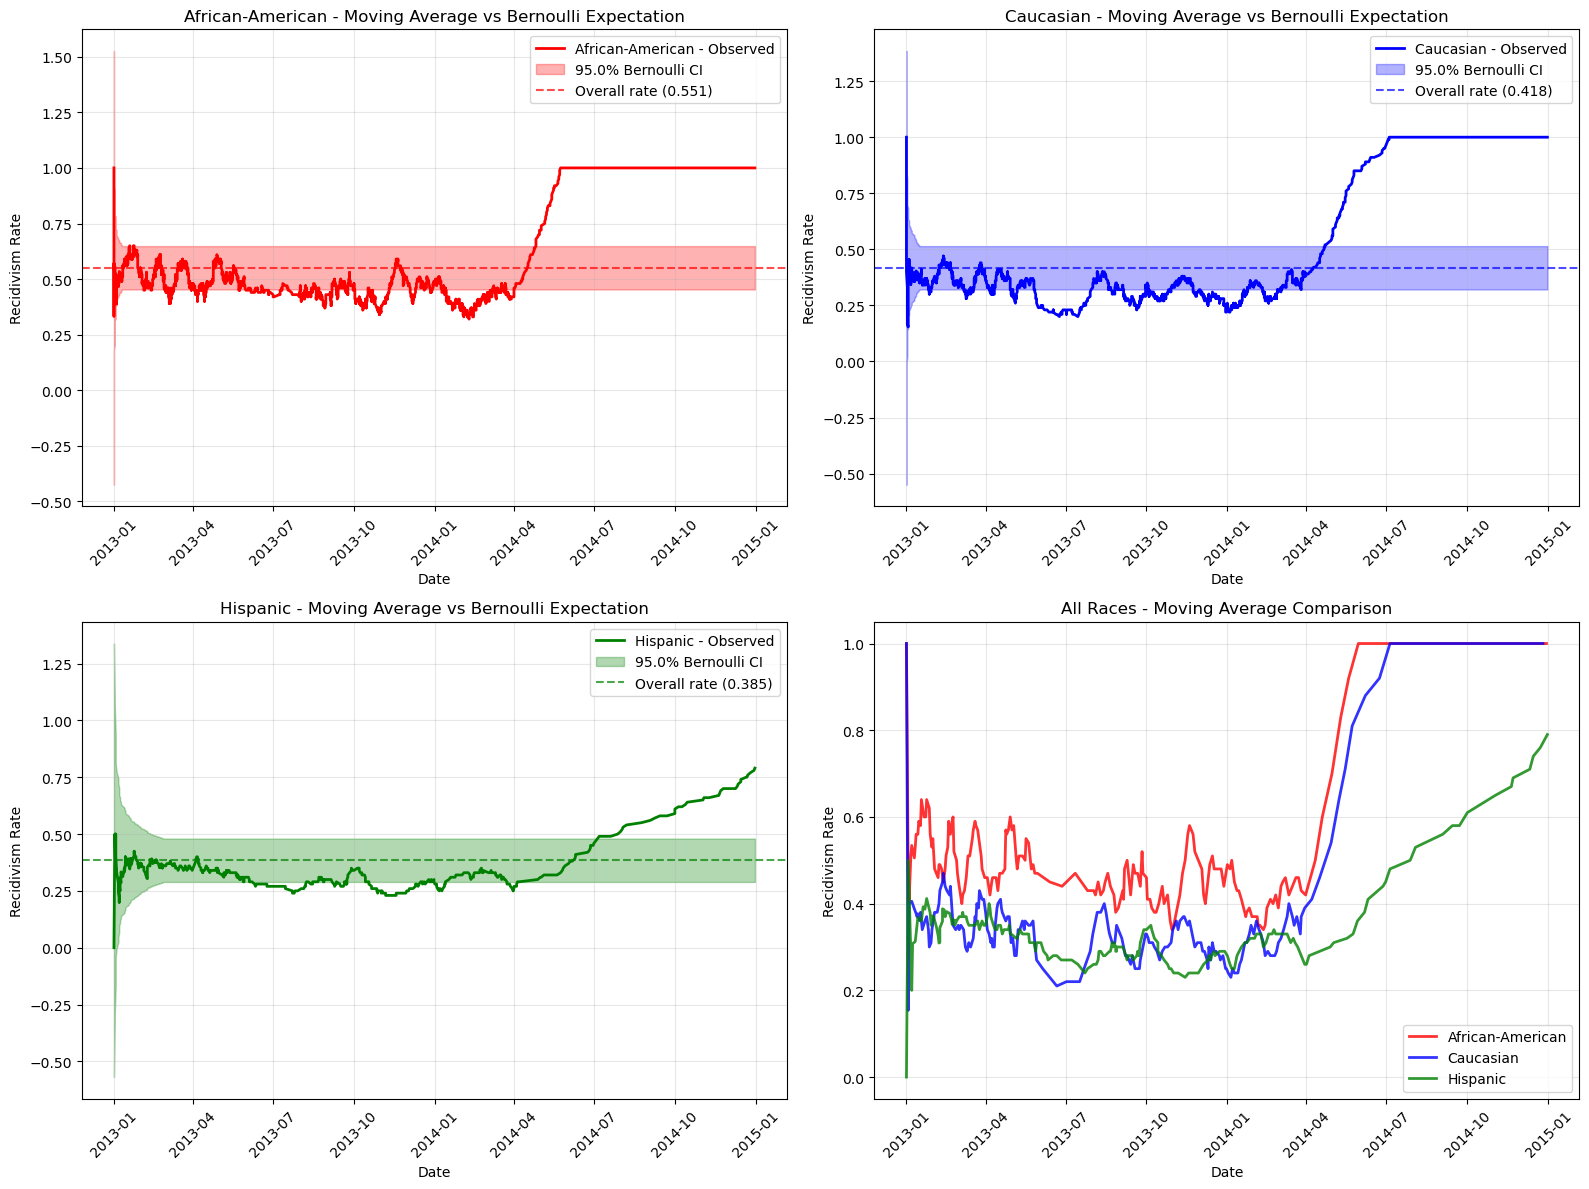


VARIANCE ANALYSIS

African-American:
  Observed variance: 0.035544
  Theoretical variance: 0.002474
  Variance ratio: 14.366
  *** HIGH VARIANCE: 14.4x more variable than Bernoulli

Caucasian:
  Observed variance: 0.044596
  Theoretical variance: 0.002432
  Variance ratio: 18.336
  *** HIGH VARIANCE: 18.3x more variable than Bernoulli

Hispanic:
  Observed variance: 0.008868
  Theoretical variance: 0.002367
  Variance ratio: 3.747
  *** HIGH VARIANCE: 3.7x more variable than Bernoulli

INTERPRETATION GUIDE:
1. If violation rates significantly exceed 5% (for 95% CI):
   → Moving average fluctuations are NOT just random noise
   → There may be systematic patterns or temporal trends

2. If variance ratios > 1.5:
   → More variability than expected from Bernoulli process
   → Suggests non-random factors influencing recidivism

3. If variance ratios < 0.67:
   → Less variability than expected (over-dispersion)
   → May indicate measurement issues or strong constraints


In [9]:
# Analysis of Moving Average Fluctuations vs Bernoulli Distribution
# Compare observed fluctuations to expected Bernoulli noise

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import binom
import seaborn as sns

# Parameters
window_size = 100  # Should match your moving average window
confidence_level = 0.95
alpha = 1 - confidence_level

# Group data by race and calculate moving averages
races = ['African-American', 'Caucasian', 'Hispanic']
race_colors = ['red', 'blue', 'green']

plt.figure(figsize=(16, 12))

for i, race in enumerate(races):
    # Filter data for current race
    race_data = df[df['race'] == race].copy()
    race_data = race_data.sort_values('compas_screening_date')
    
    # Calculate moving average
    race_data['moving_avg'] = race_data['is_recid'].rolling(window=window_size, min_periods=1).mean()
    
    # Calculate overall recidivism rate for this race (used as Bernoulli p)
    overall_rate = race_data['is_recid'].mean()
    
    # Generate theoretical Bernoulli confidence intervals
    n_obs = len(race_data)
    positions = np.arange(n_obs)
    
    # Calculate theoretical confidence intervals for moving average
    # For a moving window, the effective sample size is min(window_size, position+1)
    theoretical_upper = []
    theoretical_lower = []
    
    for pos in positions:
        effective_n = min(window_size, pos + 1)
        # Use binomial confidence interval
        # For moving average of Bernoulli, variance = p(1-p)/n
        std_error = np.sqrt(overall_rate * (1 - overall_rate) / effective_n)
        
        # Normal approximation for confidence interval
        z_score = stats.norm.ppf(1 - alpha/2)
        margin_error = z_score * std_error
        
        theoretical_upper.append(overall_rate + margin_error)
        theoretical_lower.append(overall_rate - margin_error)
    
    # Plot the data
    plt.subplot(2, 2, i+1)
    
    # Plot actual moving average
    plt.plot(race_data['compas_screening_date'], race_data['moving_avg'], 
             color=race_colors[i], linewidth=2, label=f'{race} - Observed')
    
    # Plot theoretical confidence bounds
    plt.fill_between(race_data['compas_screening_date'], 
                     theoretical_lower, theoretical_upper,
                     alpha=0.3, color=race_colors[i], 
                     label=f'{confidence_level*100}% Bernoulli CI')
    
    # Plot overall rate line
    plt.axhline(y=overall_rate, color=race_colors[i], linestyle='--', alpha=0.7,
                label=f'Overall rate ({overall_rate:.3f})')
    
    plt.title(f'{race} - Moving Average vs Bernoulli Expectation')
    plt.xlabel('Date')
    plt.ylabel('Recidivism Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Statistical test - count violations of confidence interval
    violations = np.sum((race_data['moving_avg'] > theoretical_upper) | 
                       (race_data['moving_avg'] < np.array(theoretical_lower)))
    total_points = len(race_data)
    violation_rate = violations / total_points
    expected_violation_rate = alpha  # Should be ~5% for 95% CI
    
    print(f"\n{race} Statistical Analysis:")
    print(f"  Overall recidivism rate: {overall_rate:.3f}")
    print(f"  CI violations: {violations}/{total_points} ({violation_rate:.3f})")
    print(f"  Expected violation rate: {expected_violation_rate:.3f}")
    print(f"  Excess violations: {violation_rate - expected_violation_rate:.3f}")
    
    # Perform binomial test to see if violation rate is significantly different
    binom_pvalue = binom.cdf(violations, total_points, alpha)
    if violations > expected_violation_rate * total_points:
        binom_pvalue = 1 - binom_pvalue
    
    print(f"  Binomial test p-value: {binom_pvalue:.6f}")
    
    if binom_pvalue < 0.05:
        print(f"  *** SIGNIFICANT: Fluctuations exceed Bernoulli expectation (p < 0.05)")
    else:
        print(f"  Non-significant: Fluctuations consistent with Bernoulli noise")

# Overall comparison plot
plt.subplot(2, 2, 4)
for i, race in enumerate(races):
    race_data = df[df['race'] == race].copy()
    race_data = race_data.sort_values('compas_screening_date')
    race_data['moving_avg'] = race_data['is_recid'].rolling(window=window_size, min_periods=1).mean()
    
    # Subsample for cleaner visualization
    step = max(1, len(race_data) // 200)  # Show ~200 points max
    plt.plot(race_data['compas_screening_date'][::step], 
             race_data['moving_avg'][::step], 
             color=race_colors[i], linewidth=2, label=f'{race}', alpha=0.8)

plt.title('All Races - Moving Average Comparison')
plt.xlabel('Date')
plt.ylabel('Recidivism Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Additional analysis: Variance comparison
print("\n" + "="*50)
print("VARIANCE ANALYSIS")
print("="*50)

for race in races:
    race_data = df[df['race'] == race].copy()
    race_data = race_data.sort_values('compas_screening_date')
    race_data['moving_avg'] = race_data['is_recid'].rolling(window=window_size, min_periods=1).mean()
    
    overall_rate = race_data['is_recid'].mean()
    
    # Observed variance in moving average
    observed_var = np.var(race_data['moving_avg'], ddof=1)
    
    # Theoretical variance for Bernoulli moving average
    # This is approximate - actual variance depends on window position
    theoretical_var = overall_rate * (1 - overall_rate) / window_size
    
    # Variance ratio
    variance_ratio = observed_var / theoretical_var
    
    print(f"\n{race}:")
    print(f"  Observed variance: {observed_var:.6f}")
    print(f"  Theoretical variance: {theoretical_var:.6f}")
    print(f"  Variance ratio: {variance_ratio:.3f}")
    
    if variance_ratio > 1.5:
        print(f"  *** HIGH VARIANCE: {variance_ratio:.1f}x more variable than Bernoulli")
    elif variance_ratio < 0.67:
        print(f"  *** LOW VARIANCE: {variance_ratio:.1f}x less variable than Bernoulli")
    else:
        print(f"  Variance consistent with Bernoulli expectation")

print("\n" + "="*50)
print("INTERPRETATION GUIDE:")
print("="*50)
print("1. If violation rates significantly exceed 5% (for 95% CI):")
print("   → Moving average fluctuations are NOT just random noise")
print("   → There may be systematic patterns or temporal trends")
print("\n2. If variance ratios > 1.5:")
print("   → More variability than expected from Bernoulli process")
print("   → Suggests non-random factors influencing recidivism")
print("\n3. If variance ratios < 0.67:")
print("   → Less variability than expected (over-dispersion)")
print("   → May indicate measurement issues or strong constraints")

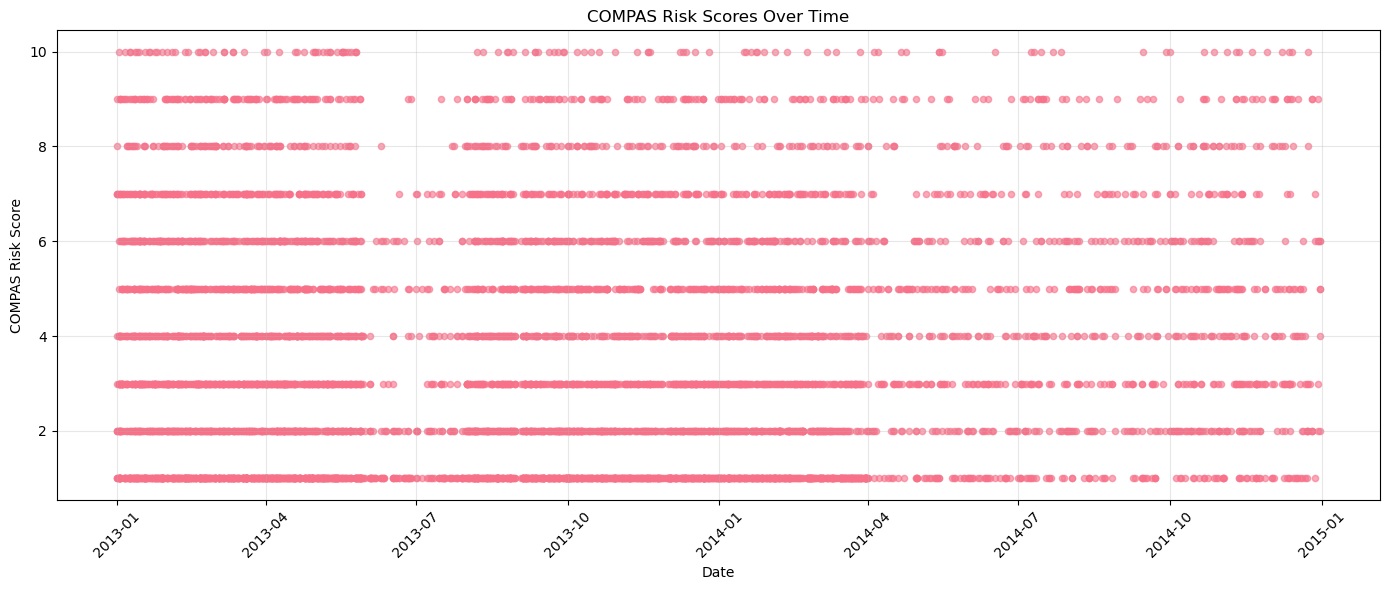

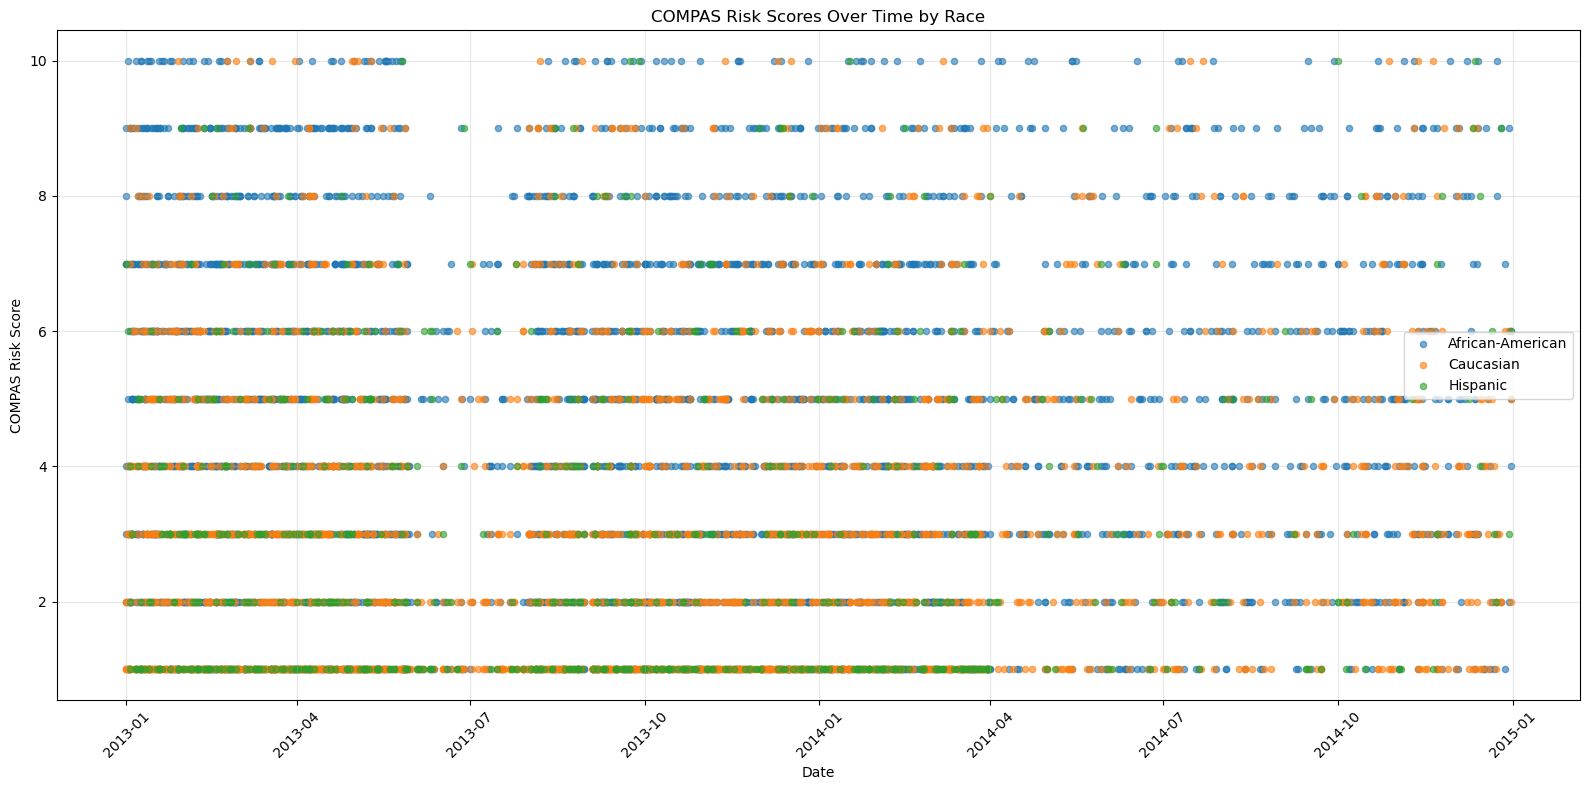

In [20]:
# Risk scores over time
plt.figure(figsize=(14, 6))
plt.scatter(df['compas_screening_date'], df['v_decile_score'], alpha=0.6, s=20)
plt.xlabel('Date')
plt.ylabel('COMPAS Risk Score')
plt.title('COMPAS Risk Scores Over Time')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Risk scores by race
plt.figure(figsize=(16, 8))
for i, race in enumerate(order):
    race_data = df[df['race'] == race]
    plt.scatter(race_data['compas_screening_date'], race_data['v_decile_score'], 
               alpha=0.6, s=20, label=race, color=colors[i])

plt.xlabel('Date')
plt.ylabel('COMPAS Risk Score')
plt.title('COMPAS Risk Scores Over Time by Race')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Run OnlineMA

In [2]:
# COMPAS OnlineMA demo (uses df with columns: 'race', 'is_recid', 'v_decile_score')
# Builds race groups, uses external p̃ = v_decile_score/10, runs OnlineMA, and saves smoothed MA plots.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Output directory for plots
plots_dir = os.path.join(os.getcwd(), "plots")
os.makedirs(plots_dir, exist_ok=True)

def rolling_mean(arr, window, *, min_periods=1, center=False):
    s = pd.Series(np.asarray(arr, dtype=float))
    return s.rolling(window=window, min_periods=min_periods, center=center).mean().to_numpy()

def rolling_vec_norm(V, window, *, norm= "l_infty", min_periods=1, center=False):
    """
    V: length-T list of numpy arrays (m,)
    Returns length-T array: || rolling_norm_t(g) ||_{norm}
    """
    df = pd.DataFrame(np.asarray(V, float))
    mu = df.rolling(window=window, min_periods=min_periods, center=center).mean()

    if norm == "l2":
        return np.linalg.norm(mu.to_numpy(), ord=2, axis=1)
    elif norm == "l_infty":
        return np.max(np.abs(mu.to_numpy()), axis=1)
    else:
        raise ValueError("norm must be 'l2' or 'l_infty'.")

In [3]:
# 1) Select required columns and clean
df = pd.read_csv('./raw_data/compas-scores-two-years.csv')
df = df[['compas_screening_date', 'sex', 'race', 'v_decile_score', 'is_recid']]
df = df[df.race.isin(["African-American", "Caucasian", "Hispanic"])]
df.compas_screening_date = pd.to_datetime(df.compas_screening_date)

# drop rows after 2014-04-01 (keep rows on or before this date)
cutoff = pd.Timestamp('2014-04-01')
df = df[df.compas_screening_date <= cutoff]

df_req = df.sort_values(by='compas_screening_date', ignore_index=True)
df_req['p_tilde'] = df_req['v_decile_score'] / 10.0

Saved initial moving-average plot to: /wynton/protected/home/ibrahim/jivatkaur/adaptive-multiobjective/notebooks/plots/compas_initial_y_moving_average_w400.png


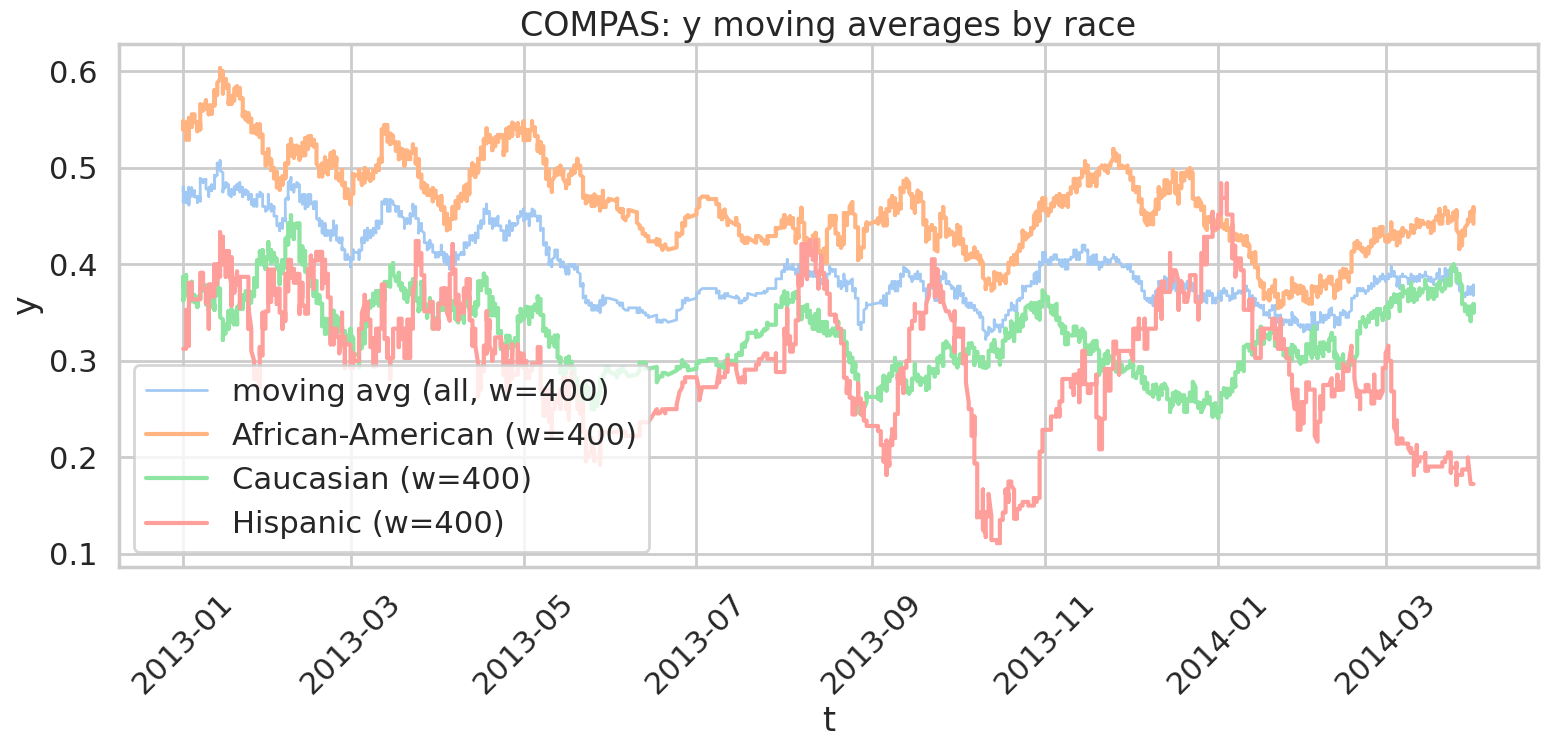

In [ ]:
# 2) Initial plot of y moving averages (overall + per race)
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("pastel")

window_plot_y = 400

y = df_req['is_recid'].astype(float)
y_ma = y.rolling(window=window_plot_y, center=True, min_periods=1).mean()

plt.figure(figsize=(16, 8))
# plt.plot(df_req['compas_screening_date'], y, alpha=0.25, label="y (all)")
plt.plot(df_req['compas_screening_date'], y_ma, linewidth=2, label=f"moving avg (all, w={window_plot_y})")

races = df_req['race'].astype('category')
order = list(races.cat.categories)
for g_name in order:
    s_g = y.where(races == g_name)  
    ma_g = s_g.rolling(window=window_plot_y, center=True, min_periods=1).mean()
    plt.plot(df_req['compas_screening_date'], ma_g, label=f"{g_name} (w={window_plot_y})")

plt.xlabel("t")
plt.ylabel("y")
plt.title("COMPAS: y moving averages by race")
plt.legend()
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()

init_path = os.path.join(plots_dir, f"compas_initial_y_moving_average_w{window_plot_y}.png")
plt.savefig(init_path, dpi=150)
# plt.close()
print(f"Saved initial moving-average plot to: {init_path}")



Plotting moving averages:
African-American: plotting 3040 points from 2013-01-05 to 2014-03-21
Caucasian: plotting 2033 points from 2013-01-10 to 2014-03-20
Hispanic: plotting 464 points from 2013-02-05 to 2014-02-21


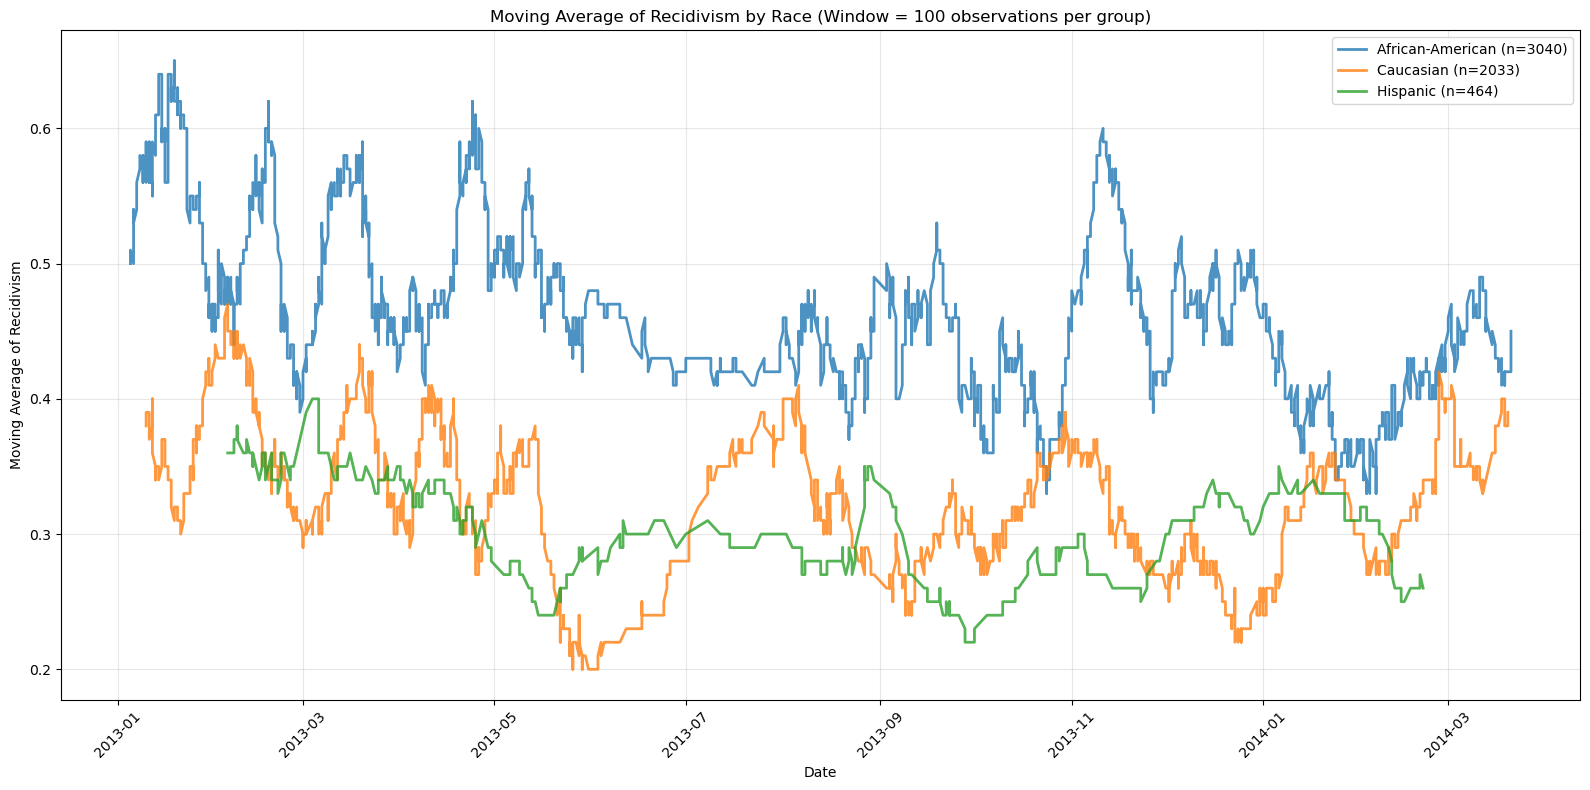

In [16]:
# Calculate moving averages for each racial group
window_size_group = 100  # Smaller window since each group has fewer observations
df_moving_avg_by_race = []

for race in order:
    race_data = df[df['race'] == race].sort_values('compas_screening_date').reset_index(drop=True)
    if len(race_data) >= window_size_group:
        race_data['moving_avg'] = race_data['is_recid'].rolling(window=window_size_group, center=True).mean()
        race_data['race'] = race
        df_moving_avg_by_race.append(race_data)
    else:
        print(f"Warning: {race} has only {len(race_data)} observations, skipping moving average")

print(f"\nPlotting moving averages:")
plt.figure(figsize=(16, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

for i, race in enumerate(order):
    # Find the corresponding dataframe for this race
    race_df = None
    for df_race in df_moving_avg_by_race:
        if df_race['race'].iloc[0] == race:
            race_df = df_race
            break
    
    if race_df is not None:
        # Remove NaN values for plotting
        race_df_clean = race_df.dropna(subset=['moving_avg'])
        if len(race_df_clean) > 0:
            print(f"{race}: plotting {len(race_df_clean)} points from {race_df_clean['compas_screening_date'].min().strftime('%Y-%m-%d')} to {race_df_clean['compas_screening_date'].max().strftime('%Y-%m-%d')}")
            plt.plot(race_df_clean['compas_screening_date'], race_df_clean['moving_avg'], 
                    linewidth=2, label=f"{race} (n={len(race_df_clean)})", alpha=0.8, color=colors[i])
        else:
            print(f"{race}: no valid moving average points to plot")
    else:
        print(f"{race}: no moving average data available")

plt.xlabel('Date')
plt.ylabel('Moving Average of Recidivism')
plt.title(f'Moving Average of Recidivism by Race (Window = {window_size_group} observations per group)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



In [4]:
window = 10
window_plot = 10
eta = 0.005
loss = "log"

# 3) Build arrays aligned to df_req index (0..T-1)
num_obs = len(df_req)
X = np.zeros((num_obs, 1), dtype=float) 
y = df_req['is_recid'].to_numpy(dtype=float)
p_tilde_seq = df_req['p_tilde'].to_numpy(dtype=float)
G_df = pd.get_dummies(df_req['race'].astype('category'), drop_first=False)
G = G_df.to_numpy(dtype=float)
num_groups = G.shape[1]
print("number of groups: ", num_groups)

# Group by date and use the (now) positional indices to slice arrays
by_date = df_req.groupby('compas_screening_date', sort=True)
T = len(by_date)

# 4) Online learner (uses external p̃; β-step skipped internally)
maonly = OnlineMA(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss)
maonly_nonadaptive = OnlineMA(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=False)
mareg = OnlineMARegret(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss)
mareg_nonadaptive = OnlineMARegret(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=False)

# Track metrics
ptilde_baseline_ma_losses = []
maonly_baseline_ma_losses, maonly_baseline_lreg = [], []
maonly_nonadaptive_ma_losses, maonly_nonadaptive_lreg = [], []
mareg_ma_losses, mareg_l_reg = [], []
mareg_nonadaptive_ma_losses, mareg_nonadaptive_l_reg = [], []

for date, df_d in tqdm(by_date, total=len(by_date)):
    # Build batch for this date
    idxs = df_d.index.to_numpy()
    x_batch = X[idxs]                                  # (b, d)
    y_batch = y[idxs].astype(float)                    # (b,)
    g_batch = G[idxs]                                  # (b, m)
    pt_batch = p_tilde_seq[idxs].astype(float)         # (b,)

    # Baseline from p̃: use expected group residual vector over the batch
    vec_ptilde = (g_batch * (y_batch - pt_batch)[:, None]).mean(axis=0)
    # print("vec_ptilde", vec_ptilde)
    ptilde_baseline_ma_losses.append(vec_ptilde)

    # Baseline: MA-only baseline (no regret term).
    metrics = maonly.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    maonly_baseline_ma_losses.append(metrics["ma_losses"])
    maonly_baseline_lreg.append(metrics["l_reg"])

    # Baseline: Non-adaptive MA-only
    metrics = maonly_nonadaptive.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    maonly_nonadaptive_ma_losses.append(metrics["ma_losses"])
    maonly_nonadaptive_lreg.append(metrics["l_reg"])

    # Baseline: Non-adaptive MA+reg
    metrics = mareg_nonadaptive.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    mareg_nonadaptive_ma_losses.append(metrics["ma_losses"])
    mareg_nonadaptive_l_reg.append(metrics["l_reg"])
   
    # Model update with external p̃ (β-step skipped internally), batched
    metrics = mareg.update(x_batch, y_batch, g_batch, p_tilde=pt_batch)
    mareg_ma_losses.append(metrics["ma_losses"])
    mareg_l_reg.append(metrics["l_reg"])

ptilde_baseline_ma_l2 = rolling_vec_norm(ptilde_baseline_ma_losses, window_plot, norm="l2")
ptilde_baseline_ma_linf = rolling_vec_norm(ptilde_baseline_ma_losses, window_plot, norm="l_infty")
maonly_baseline_ma_l2 = rolling_vec_norm(maonly_baseline_ma_losses, window_plot, norm="l2")
maonly_baseline_ma_linf = rolling_vec_norm(maonly_baseline_ma_losses, window_plot, norm="l_infty")
maonly_baseline_lreg = rolling_mean(maonly_baseline_lreg, window_plot)
maonly_nonadaptive_ma_l2 = rolling_vec_norm(maonly_nonadaptive_ma_losses, window_plot, norm="l2")
maonly_nonadaptive_ma_linf = rolling_vec_norm(maonly_nonadaptive_ma_losses, window_plot, norm="l_infty")
maonly_nonadaptive_lreg = rolling_mean(maonly_nonadaptive_lreg, window_plot)
mareg_nonadaptive_ma_l2 = rolling_vec_norm(mareg_nonadaptive_ma_losses, window_plot, norm="l2")
mareg_nonadaptive_ma_linf = rolling_vec_norm(mareg_nonadaptive_ma_losses, window_plot, norm="l_infty")
mareg_nonadaptive_l_reg = rolling_mean(mareg_nonadaptive_l_reg, window_plot)
mareg_ma_l2 = rolling_vec_norm(mareg_ma_losses, window_plot, norm="l2")
mareg_ma_linf = rolling_vec_norm(mareg_ma_losses, window_plot, norm="l_infty")
mareg_lreg = rolling_mean(mareg_l_reg, window_plot)

# 5) Plot L_infty
plt.figure(figsize=(9, 3))
plt.plot(ptilde_baseline_ma_linf, label=f"p~ baseline")
plt.plot(maonly_baseline_ma_linf, label=f"MA-only")
plt.plot(maonly_nonadaptive_ma_linf, label=f"MA-only (non-adaptive)")
plt.plot(mareg_nonadaptive_ma_linf, label=f"MA+reg (non-adaptive)")
plt.plot(mareg_ma_linf, label=f"MA+reg")

plt.xlabel("t")
plt.ylabel(r"$L_\infty$ MA error")
plt.title(f"COMPAS: Smoothed L_\infty MA error (w_alg={window}, w_plot={window_plot})")
plt.legend()
plt.tight_layout()
out_inf = os.path.join(plots_dir, f"compas_ma_error_linf_walg{window}_wplot{window_plot}.png")
plt.savefig(out_inf, dpi=150)
plt.close()

# 6) Plot L2
plt.figure(figsize=(9, 3))
plt.plot(ptilde_baseline_ma_l2, label=f"p~ baseline")
plt.plot(maonly_baseline_ma_l2, label=f"MA-only")
plt.plot(maonly_nonadaptive_ma_l2, label=f"MA-only (non-adaptive)")
plt.plot(mareg_nonadaptive_ma_l2, label=f"MA+reg (non-adaptive)")
plt.plot(mareg_ma_l2, label=f"MA+reg")
plt.xlabel("t")
plt.ylabel(r"$L_2$ MA error")
plt.title(f"COMPAS: Smoothed L2 MA error (w_alg={window}, w_plot={window_plot})")
plt.legend()
plt.tight_layout()
out_l2 = os.path.join(plots_dir, f"compas_ma_error_l2_walg{window}_wplot{window_plot}.png")
plt.savefig(out_l2, dpi=150)
plt.close()

# 7) Plot L_reg 
plt.figure(figsize=(9, 3))
plt.plot(maonly_baseline_lreg, label=f"MA-only")
plt.plot(maonly_nonadaptive_lreg, label=f"MA-only (non-adaptive)")
plt.plot(mareg_nonadaptive_l_reg, label=f"MA+reg (non-adaptive)")
plt.plot(mareg_lreg, label=f"MA+reg")
plt.xlabel("t")
plt.ylabel("regret")
plt.title(f"COMPAS: Smoothed regret (w_alg={window}, w_plot={window_plot})")
plt.legend()
plt.tight_layout()
out_reg = os.path.join(plots_dir, f"compas_lreg_walg{window}_wplot{window_plot}.png")
plt.savefig(out_reg, dpi=150)
plt.close()

print("Saved plots:\n -", out_inf, "\n -", out_l2, "\n -", out_reg)

number of groups:  3


 15%|█▍        | 63/433 [00:13<01:16,  4.84it/s] 


KeyboardInterrupt: 